In [1]:
struct PDEVars{T}
    Phi::T
    PhiZ::T
    PhiZZ::T
    S::T
    SZ::T
    SZZ::T
    Sdot::T
    SdotZ::T
    SdotZZ::T
    Phidot::T
    PhidotZ::T
    PhidotZZ::T
    A::T
    AZ::T
    AZZ::T
    z::T
    LN::T
    t::T
    X::T
    p2::T
    a4::T
    DS0::T
    DS1::T
    DS2::T
    DS3::T
    DS4::T
end

In [70]:
# A rewrite of the code to make it easier to deal with. 
# We now allow for a multi-grid solver with uneven lengths and different resolutions.
# State vector: [t, ξ, p_2, a_4], var_vec.
# var_vec: Phi, S, Sdot, PhiDot, A.
T = BigFloat;
setprecision(T, 256);
using Plots
using Parameters: @unpack

include("cheb.jl")
include("Equation expressions/ODECoeffExpr.jl");
include("Equation expressions/CosmoS0Expr.jl");
include("solvers.jl")

#Properties of this simulation:

global const H = T(3.);
global const Om = T(4.);
global const tstar = 1;
global const M = 1;
global zAH = T(1/2);

global const z_boundaries = [0, 0.15, 0.3, 0.5, 0.6]; #Boundaries of grid domains.
global const domain_sizes = [15, 20, 15, 15]; #sizes of all domains.
global const Ndom = length(domain_sizes);

global const zero_var = [zeros(T,n) for n in domain_sizes]; #Helpful for getting arrays of the right shape

diff2_mats, diff1_mats, grids = MultiGridChebyshev(z_boundaries, domain_sizes);

Vfun(x) = ( -576. - 288. * x^2 - 64. * x^4 + 22. * x^6 - x^8) / 192.;
DV(x) = - x * (144. + 64. * x^2 - 33. * x^4 + 2. * x^6) / 48.;


In [68]:
InitVar = [copy(zero_var) for var in 1:NVar];
state_vec = [[T(-3), 0, 0, -T(100.)], InitVar];

In [71]:
Var = copy(InitVar);
init_params = [T(-3), 0, 0, -T(100.)];

VarZ,VarZZ = ComputeDerivatives(Var);

for ii in 1:100
    Var[ind_s] = LinearSolveODE(1, init_params, Var, VarZ, VarZZ);
    VarZ[ind_s] = ComputeSingleDerivative(Var[ind_s]);
    VarZZ[ind_s] = ComputeSingleDerivative(Var[ind_s], deg=2);

    Var[ind_sdot] = LinearSolveODE(2, init_params, Var, VarZ, VarZZ);
    VarZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot]);
    VarZZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot], deg=2);

    newX = CorrectXi(init_params, Var);
    print("\rX = $newX");
    flush(stdout);

    init_params[ind_X] = newX;
end

LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching getindex(::typeof(Vfun), ::BigFloat)
    The function `getindex` exists, but no method is defined for this combination of argument types.
    Stacktrace:
     [1] [0m[1mSdotSrc[22m[0m[1m([22m[90mv[39m::[0mPDEVars[90m{BigFloat}[39m[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m~/Documents/Holography with dynamic boundary/Reproducing-Dynamic-Holo/Equation expressions/[39m[90m[4mODECoeffExpr.jl:86[24m[39m
     [2] [0m[1mComputeODEMatrix[22m[0m[1m([22m[90mEqNum[39m::[0mInt64, [90mdomind[39m::[0mInt64, [90mparams[39m::[0mVector[90m{BigFloat}[39m, [90mVar[39m::[0mVector[90m{Vector{Vector{BigFloat}}}[39m, [90mVarZ[39m::[0mVector[90m{Vector{Vector{BigFloat}}}[39m, [90mVarZZ[39m::[0mVector[90m{Vector{Vector{BigFloat}}}[39m[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m~/Documents/Holography with dynamic boundary/Reproducing-Dynamic-Holo/[39m[90m[4msolvers.jl:197[24m[39m
     [3] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/Documents/Holography with dynamic boundary/Reproducing-Dynamic-Holo/[39m[90m[4msolvers.jl:321[24m[39m[90m [inlined][39m
     [4] [0m[1m(::var"#LinearSolveODE##52#LinearSolveODE##53"{var"#LinearSolveODE##54#LinearSolveODE##55"{Int64, Vector{BigFloat}, Vector{Vector{Vector{BigFloat}}}, Vector{Vector{Vector{BigFloat}}}, Vector{Vector{Vector{BigFloat}}}, Vector{Vector{BigFloat}}, Vector{Vector{BigFloat}}, Int64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:276[24m[39m
     [5] [0m[1m#LinearSolveODE##52[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:243[24m[39m[90m [inlined][39m
     [6] [0m[1m(::Base.Threads.var"#threading_run##0#threading_run##1"{var"#LinearSolveODE##52#LinearSolveODE##53"{var"#LinearSolveODE##54#LinearSolveODE##55"{Int64, Vector{BigFloat}, Vector{Vector{Vector{BigFloat}}}, Vector{Vector{Vector{BigFloat}}}, Vector{Vector{Vector{BigFloat}}}, Vector{Vector{BigFloat}}, Vector{Vector{BigFloat}}, Int64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:177[24m[39m

...and 3 more exceptions.


In [9]:
testfoo = t->t.^(5/4);
testderfoo = t->(5/4).*t.^(1/4);

testvec = testfoo.(grids);
testder = ComputeSingleDerivative(testvec, deg=1);

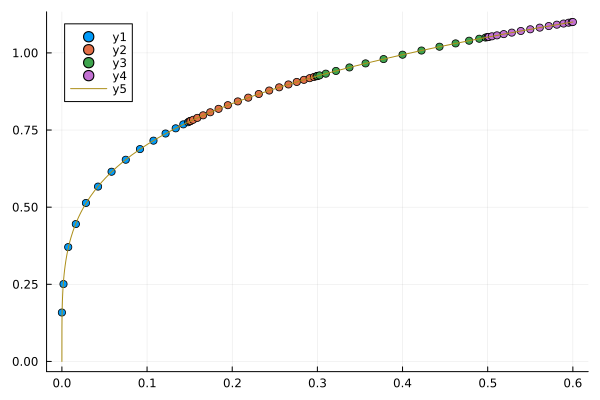

In [10]:
scatter(grids, testder)
plot!(testderfoo, 0,0.6)